In [1]:
#Essentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import time
import datetime
import itertools
import plotly.offline as pyoff
import plotly.graph_objs as go
from sklearn.preprocessing import MinMaxScaler, StandardScaler

#Forcasting machine = facebook-Prophet
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from fbprophet.diagnostics import cross_validation, performance_metrics

#Data transformer = BoxCox to make it more normal distribution
from scipy.stats import boxcox
from scipy.special import inv_boxcox


In [2]:
ls

ChurnPredict/                  StockForcast/
Data_Analysis_Python/          Untitled.ipynb
Databases_SQL/                 WeatherForecast.ipynb
GoogleAPITest/                 analytics-quickstart/
Housing_Price_Scotland/        denpasar_weather.zip
ML_Notes/                      drugtree.png
MyGAPITrial-ea1c5ea77568.json  openweatherdata-denpasar-1990-2020.csv
PCA/                           openweatherdata-denpasar-1990-2020v0.1.csv
PCA_try.ipynb                  skillsnetwork/
Pressure1.csv                  source/
SpectraIntegration/            soy-pillar-299102-fd620555a9c2.json
SpectraIntegration.py          test_Spectra.txt


In [3]:
df = pd.read_csv('openweatherdata-denpasar-1990-2020.csv')

In [4]:
df.shape

(264924, 32)

In [5]:
df.dtypes

dt                       int64
dt_iso                  object
timezone                 int64
city_name               object
lat                    float64
lon                    float64
temp                   float64
temp_min               float64
temp_max               float64
pressure               float64
sea_level              float64
grnd_level             float64
humidity                 int64
wind_speed             float64
wind_deg                 int64
rain_1h                float64
rain_3h                float64
rain_6h                float64
rain_12h               float64
rain_24h               float64
rain_today             float64
snow_1h                float64
snow_3h                float64
snow_6h                float64
snow_12h               float64
snow_24h               float64
snow_today             float64
clouds_all               int64
weather_id               int64
weather_main            object
weather_description     object
weather_icon            object
dtype: o

we do not really need the snow*, weather* columns and clouds

convert the unix datetime to gregorian datetime, note that Bali follow Hongkong timezone

In [6]:
df['dt'] = pd.to_datetime(df['dt'], unit='s').astype('datetime64[ns, Hongkong]').dt.tz_convert('UTC')

In [7]:
df.rain_1h

0         0.49
1         0.13
2         0.24
3         0.23
4          NaN
          ... 
264919     NaN
264920     NaN
264921     NaN
264922     NaN
264923     NaN
Name: rain_1h, Length: 264924, dtype: float64

Select Relevant parameters

In [8]:
df_sel = df[['dt', 'temp', 'pressure', 'humidity', 'wind_speed', 'rain_1h']]

In [9]:
df_sel

dt   temp  pressure  humidity  wind_speed  \
0      1990-01-01 00:00:00+00:00  25.82    1010.0        86        1.36   
1      1990-01-01 01:00:00+00:00  26.20    1011.0        84        2.09   
2      1990-01-01 02:00:00+00:00  26.45    1011.0        84        2.44   
3      1990-01-01 03:00:00+00:00  26.80    1011.0        82        2.29   
4      1990-01-01 04:00:00+00:00  27.04    1010.0        82        1.71   
...                          ...    ...       ...       ...         ...   
264919 2020-01-07 19:00:00+00:00  27.00    1007.0        94        4.10   
264920 2020-01-07 20:00:00+00:00  27.00    1007.0        94        5.70   
264921 2020-01-07 21:00:00+00:00  28.00    1007.0        83        6.70   
264922 2020-01-07 22:00:00+00:00  28.00    1007.0        83        6.20   
264923 2020-01-07 23:00:00+00:00  28.00    1008.0        83        5.70   

        rain_1h  
0          0.49  
1          0.13  
2          0.24  
3          0.23  
4           NaN  
...         ...  
264919      NaN  
264920      NaN  
264921      NaN  
264922      NaN  
264923      NaN  

[264924 rows x 6 columns]

Lets assume that the NaN in the rain means there it was not raining at that time, so I will give value of 0 in at that period

In [10]:
df_sel['rain_1h'].fillna(0, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:4536: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [11]:
df_sel

dt   temp  pressure  humidity  wind_speed  \
0      1990-01-01 00:00:00+00:00  25.82    1010.0        86        1.36   
1      1990-01-01 01:00:00+00:00  26.20    1011.0        84        2.09   
2      1990-01-01 02:00:00+00:00  26.45    1011.0        84        2.44   
3      1990-01-01 03:00:00+00:00  26.80    1011.0        82        2.29   
4      1990-01-01 04:00:00+00:00  27.04    1010.0        82        1.71   
...                          ...    ...       ...       ...         ...   
264919 2020-01-07 19:00:00+00:00  27.00    1007.0        94        4.10   
264920 2020-01-07 20:00:00+00:00  27.00    1007.0        94        5.70   
264921 2020-01-07 21:00:00+00:00  28.00    1007.0        83        6.70   
264922 2020-01-07 22:00:00+00:00  28.00    1007.0        83        6.20   
264923 2020-01-07 23:00:00+00:00  28.00    1008.0        83        5.70   

        rain_1h  
0          0.49  
1          0.13  
2          0.24  
3          0.23  
4          0.00  
...         ...  
264919     0.00  
264920     0.00  
264921     0.00  
264922     0.00  
264923     0.00  

[264924 rows x 6 columns]

it can be seen that the data were collected hourly, lets summarize it to daily data

In [12]:
df_daily = df_sel.groupby(pd.Grouper(freq='D', key='dt')).mean()

In [13]:
df_daily.reset_index(inplace=True)

In [14]:
df_daily

dt       temp     pressure   humidity  \
0     1990-01-01 00:00:00+00:00  26.333750  1009.333333  85.416667   
1     1990-01-02 00:00:00+00:00  25.559583  1009.666667  87.541667   
2     1990-01-03 00:00:00+00:00  26.956667  1008.583333  82.250000   
3     1990-01-04 00:00:00+00:00  26.638750  1007.958333  84.541667   
4     1990-01-05 00:00:00+00:00  27.940417  1007.916667  78.708333   
...                         ...        ...          ...        ...   
10959 2020-01-03 00:00:00+00:00  28.666667  1007.125000  83.583333   
10960 2020-01-04 00:00:00+00:00  28.083333  1006.000000  86.208333   
10961 2020-01-05 00:00:00+00:00  28.958333  1007.166667  86.208333   
10962 2020-01-06 00:00:00+00:00  28.708333  1007.666667  86.333333   
10963 2020-01-07 00:00:00+00:00  28.458333  1007.166667  84.916667   

       wind_speed   rain_1h  
0        1.477083  0.391667  
1        2.096667  1.529583  
2        2.122083  0.209167  
3        2.652500  0.439167  
4        2.905000  0.029583  
...           ...       ...  
10959    5.720833  0.000000  
10960    8.033333  0.000000  
10961    5.647500  0.000000  
10962    5.195833  0.000000  
10963    5.408333  0.000000  

[10964 rows x 6 columns]

In [15]:
df_daily['rain'] = df_daily['rain_1h'].apply(lambda x: 1 if x !=0 else 0)

### Now try to plot it 

In [16]:
df_daily

dt       temp     pressure   humidity  \
0     1990-01-01 00:00:00+00:00  26.333750  1009.333333  85.416667   
1     1990-01-02 00:00:00+00:00  25.559583  1009.666667  87.541667   
2     1990-01-03 00:00:00+00:00  26.956667  1008.583333  82.250000   
3     1990-01-04 00:00:00+00:00  26.638750  1007.958333  84.541667   
4     1990-01-05 00:00:00+00:00  27.940417  1007.916667  78.708333   
...                         ...        ...          ...        ...   
10959 2020-01-03 00:00:00+00:00  28.666667  1007.125000  83.583333   
10960 2020-01-04 00:00:00+00:00  28.083333  1006.000000  86.208333   
10961 2020-01-05 00:00:00+00:00  28.958333  1007.166667  86.208333   
10962 2020-01-06 00:00:00+00:00  28.708333  1007.666667  86.333333   
10963 2020-01-07 00:00:00+00:00  28.458333  1007.166667  84.916667   

       wind_speed   rain_1h  rain  
0        1.477083  0.391667     1  
1        2.096667  1.529583     1  
2        2.122083  0.209167     1  
3        2.652500  0.439167     1  
4        2.905000  0.029583     1  
...           ...       ...   ...  
10959    5.720833  0.000000     0  
10960    8.033333  0.000000     0  
10961    5.647500  0.000000     0  
10962    5.195833  0.000000     0  
10963    5.408333  0.000000     0  

[10964 rows x 7 columns]

In [17]:
print("There are {} days of raining".format(len(df_daily[df_daily['rain'] == 1])))
print("And, there are {} days of not-raining".format(len(df_daily[df_daily['rain'] == 0])))

There are 4060 days of raining
And, there are 6904 days of not-raining


Create a Random Forest Classification

In [18]:
from sklearn.tree import DecisionTreeClassifier

In [19]:
X = df_daily[['temp', 'pressure', 'humidity', 'wind_speed']].values
X

array([[  26.33375   , 1009.33333333,   85.41666667,    1.47708333],
       [  25.55958333, 1009.66666667,   87.54166667,    2.09666667],
       [  26.95666667, 1008.58333333,   82.25      ,    2.12208333],
       ...,
       [  28.95833333, 1007.16666667,   86.20833333,    5.6475    ],
       [  28.70833333, 1007.66666667,   86.33333333,    5.19583333],
       [  28.45833333, 1007.16666667,   84.91666667,    5.40833333]])

In [20]:
y = df_daily['rain'].values
y

array([1, 1, 1, ..., 0, 0, 0])

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_trainset, X_testset, y_trainset, y_testset = train_test_split(X, y, test_size=0.3, random_state=3)

In [23]:
DT = DecisionTreeClassifier(criterion="entropy", max_depth=3)
DT

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [24]:
DT.fit(X_trainset, y_trainset)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

In [25]:
predict = DT.predict(X_testset)

In [26]:
predict

array([0, 0, 0, ..., 0, 0, 1])

In [27]:
from sklearn import metrics

In [28]:
metrics.accuracy_score(y_testset, predict)

0.6404255319148936

In [29]:
!pip install pydotplus

In [30]:
from  io import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

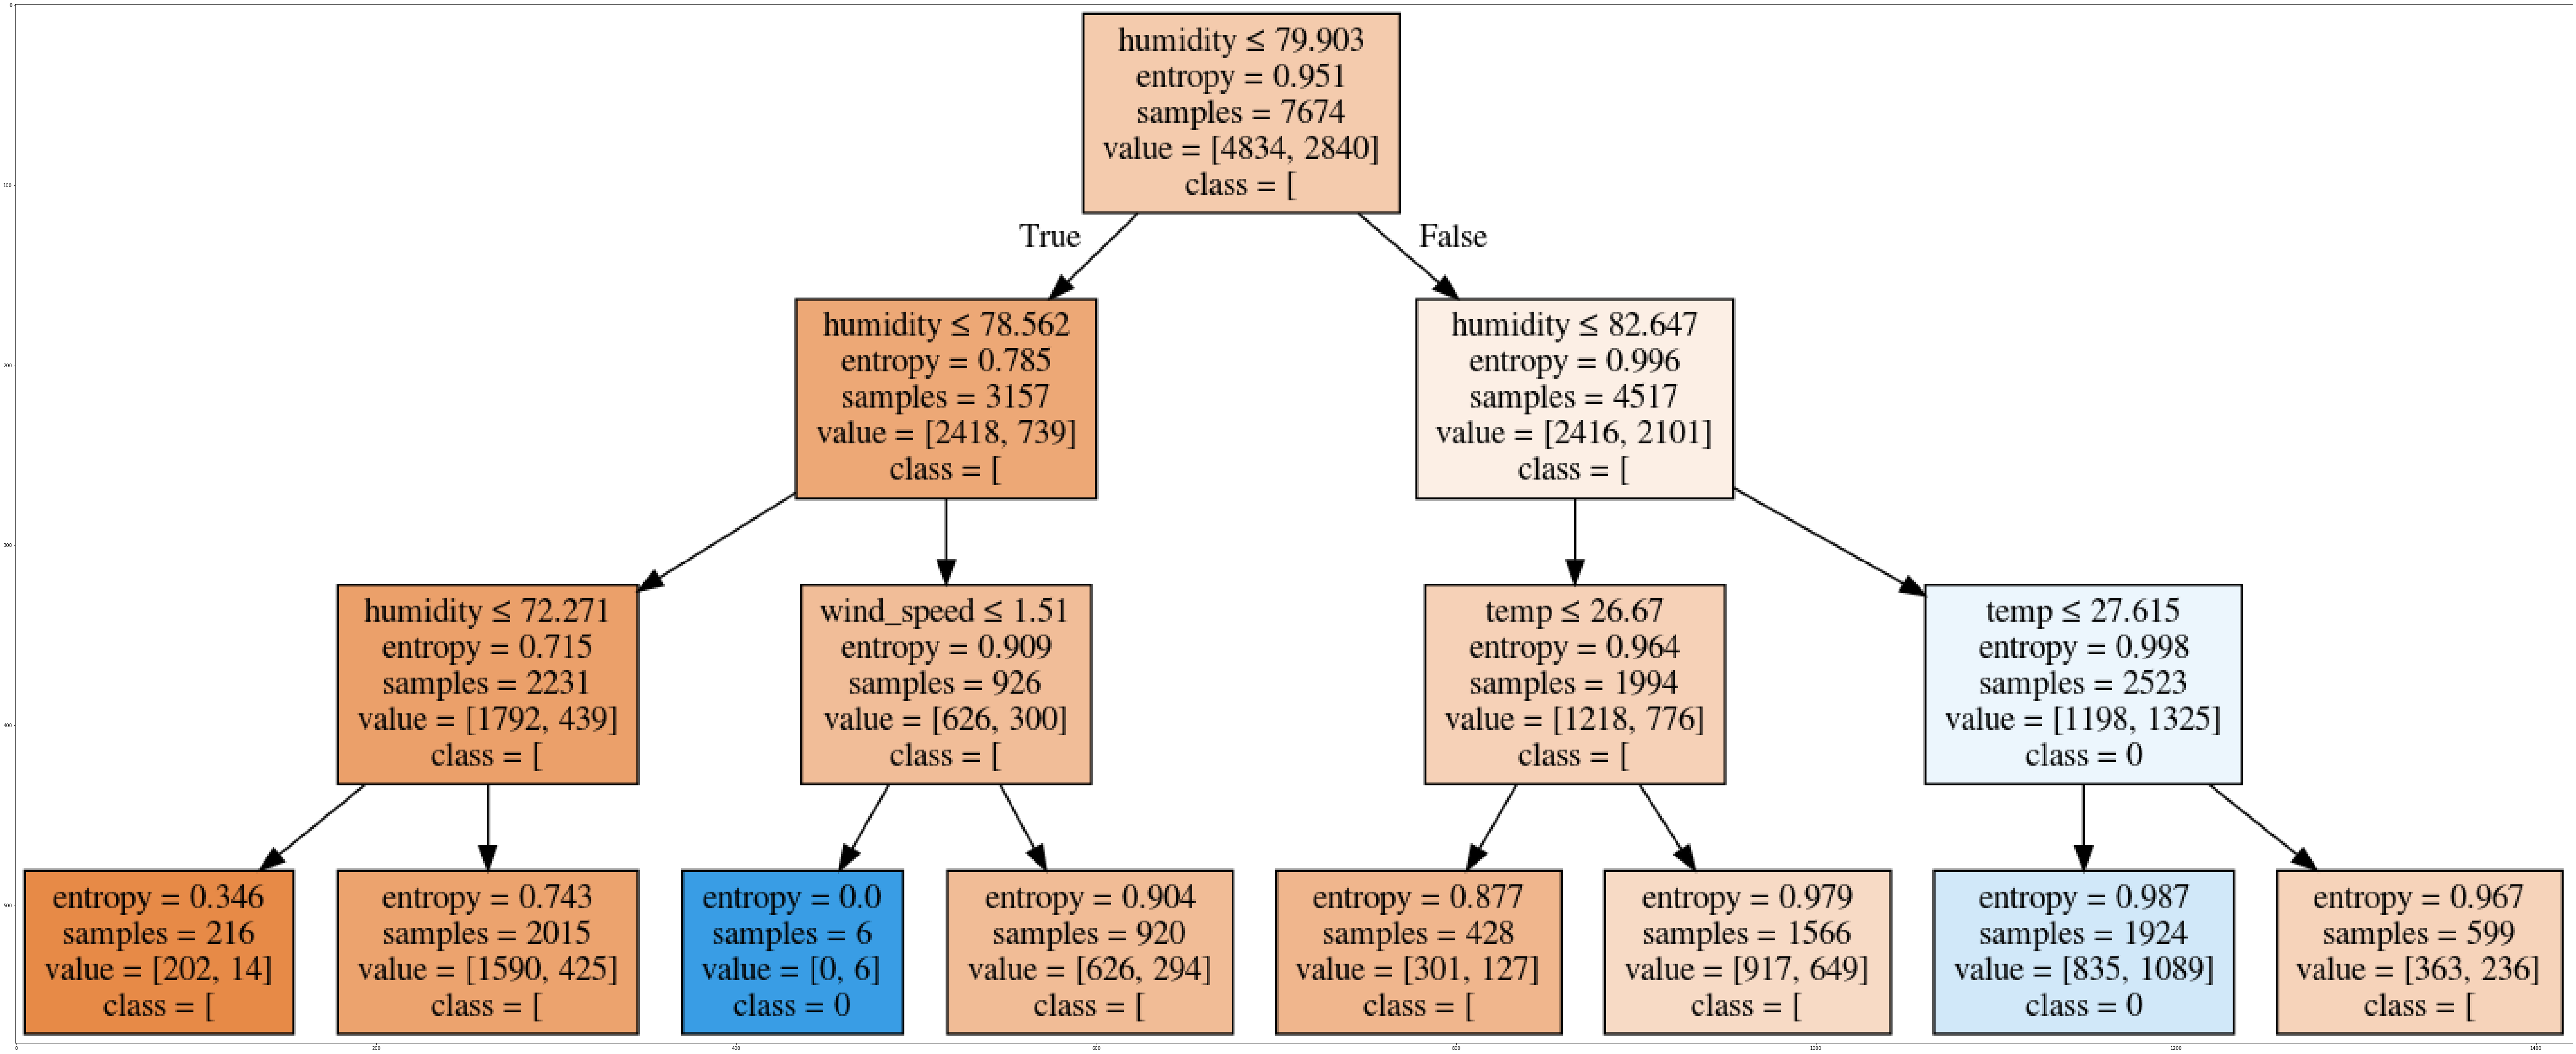

In [31]:
dot_data = StringIO()
filename = "drugtree.png"
featureNames = df_daily.columns[1:5]
targetNames = df_daily["rain"].unique().tolist()
out=tree.export_graphviz(DT,feature_names=featureNames, out_file=dot_data, class_names= str(y_trainset), filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

## FORECAST

In [32]:
df_daily.set_index('dt', inplace=True)

In [33]:
scaler = MinMaxScaler()

df_daily_sc = scaler.fit_transform(df_daily)

In [34]:
df_daily_sc = df_daily

In [35]:
df_daily_temp = df_daily['temp']

In [36]:
df_daily_temp = df_daily_temp.to_frame()

In [37]:
df_daily_temp.reset_index(inplace=True)

In [38]:
df_daily_temp.columns = ['ds', 'y']

In [39]:
df_daily_temp

ds          y
0     1990-01-01 00:00:00+00:00  26.333750
1     1990-01-02 00:00:00+00:00  25.559583
2     1990-01-03 00:00:00+00:00  26.956667
3     1990-01-04 00:00:00+00:00  26.638750
4     1990-01-05 00:00:00+00:00  27.940417
...                         ...        ...
10959 2020-01-03 00:00:00+00:00  28.666667
10960 2020-01-04 00:00:00+00:00  28.083333
10961 2020-01-05 00:00:00+00:00  28.958333
10962 2020-01-06 00:00:00+00:00  28.708333
10963 2020-01-07 00:00:00+00:00  28.458333

[10964 rows x 2 columns]

In [40]:
#Plot
fig = go.Figure()

fig.add_trace(go.Scatter(x = df_daily_temp['ds'], y=df_daily_temp['y'], name='Denpasar Temp'))
fig.show()

The data looks too 

In [41]:
# df_daily_temp.set_index('ds', inplace=True)

df_temp_sel = df_daily_temp[(df_daily_temp['ds'] >= '2010-01-01 01:00:00+00:00') & (df_daily_temp['ds'] <= '2020-01-01 00:00:00+00:00')]

# df_temp_sel.reset_index(drop=True, inplace=True)

In [42]:
df_temp_sel

ds          y
7306  2010-01-02 00:00:00+00:00  29.303750
7307  2010-01-03 00:00:00+00:00  29.280417
7308  2010-01-04 00:00:00+00:00  29.535833
7309  2010-01-05 00:00:00+00:00  28.936667
7310  2010-01-06 00:00:00+00:00  28.349583
...                         ...        ...
10953 2019-12-28 00:00:00+00:00  28.502143
10954 2019-12-29 00:00:00+00:00  29.176250
10955 2019-12-30 00:00:00+00:00  29.652917
10956 2019-12-31 00:00:00+00:00  27.989200
10957 2020-01-01 00:00:00+00:00  27.176667

[3652 rows x 2 columns]

In [43]:
#Plot
fig = go.Figure()

fig.add_trace(go.Scatter(x = df_temp_sel['ds'], y=df_temp_sel['y'], name='Denpasar Temp'))
fig.show()

In [44]:
df_temp_sel['ds'] = df_temp_sel['ds'].dt.date

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [45]:
df_daily_temp['ds'] = df_daily_temp['ds'].dt.date

So we have 2 sets of temperature data:

df_temp_sel = from 2010 to 2020
and 
df_daily_temp = from 1990 to 2020

In [46]:
#Hyperparameters
PERIODS = 360
FREQ = 'D'

#Forecasting
m = Prophet()

#Fit the data with 'ds' and 'y' as colnames
m.fit(df_daily_temp)

#Create df, holding dates for our forecast
#PERIODS = parameter couts day 
#FREQ 'D' is the for day

future = m.make_future_dataframe(periods=PERIODS, freq=FREQ)

#Create the forecast object

forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [47]:
display(forecast.tail())
display(df_daily_temp.tail())

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
11319 2020-12-28  27.534089   26.933393   29.026266    27.319443    27.797546   
11320 2020-12-29  27.534042   27.014784   29.109963    27.318937    27.799053   
11321 2020-12-30  27.533995   26.940614   29.106057    27.318432    27.799933   
11322 2020-12-31  27.533948   26.900310   29.026042    27.317927    27.801182   
11323 2021-01-01  27.533901   26.896074   28.931519    27.317421    27.802431   

       additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
11319        0.414796              0.414796              0.414796 -0.006144   
11320        0.422901              0.422901              0.422901  0.005411   
11321        0.428426              0.428426              0.428426  0.014491   
11322        0.416078              0.416078              0.416078  0.005920   
11323        0.398782              0.398782              0.398782 -0.007258   

       weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
11319     -0.006144     -0.006144  0.420939      0.420939      0.420939   
11320      0.005411      0.005411  0.417490      0.417490      0.417490   
11321      0.014491      0.014491  0.413936      0.413936      0.413936   
11322      0.005920      0.005920  0.410158      0.410158      0.410158   
11323     -0.007258     -0.007258  0.406041      0.406041      0.406041   

       multiplicative_terms  multiplicative_terms_lower  \
11319                   0.0                         0.0   
11320                   0.0                         0.0   
11321                   0.0                         0.0   
11322                   0.0                         0.0   
11323                   0.0                         0.0   

       multiplicative_terms_upper       yhat  
11319                         0.0  27.948885  
11320                         0.0  27.956943  
11321                         0.0  27.962421  
11322                         0.0  27.950026  
11323                         0.0  27.932683

ds          y
10959  2020-01-03  28.666667
10960  2020-01-04  28.083333
10961  2020-01-05  28.958333
10962  2020-01-06  28.708333
10963  2020-01-07  28.458333

In [48]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_daily_temp['ds'], y=df_daily_temp['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
# fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



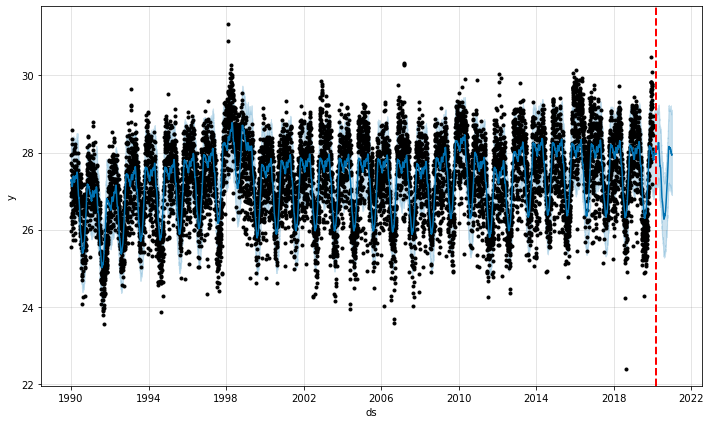

In [49]:
#Plotting with prophet built-in method
fig = m.plot(forecast)

ax = fig.add_subplot(111)
# ax.set_xlim([datetime.date(2010,1,3), datetime.date(2021,5,1)])
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('300 days'), c='red', lw=2, alpha=1, ls='--')
# ax.set_xlim([datetime.date(2019, 1, 1), datetime.date(2020, 12, 1)])
fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



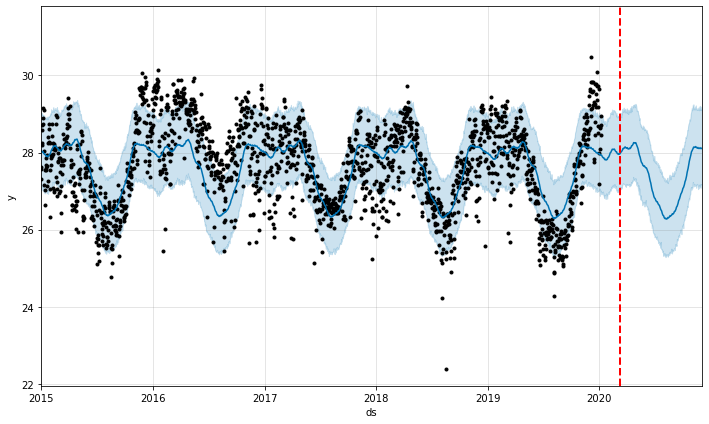

In [50]:
#Plotting with prophet built-in method
fig = m.plot(forecast)

ax = fig.add_subplot(111)
# ax.set_xlim([datetime.date(2010,1,3), datetime.date(2021,5,1)])
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('300 days'), c='red', lw=2, alpha=1, ls='--')
ax.set_xlim([datetime.date(2015, 1, 1), datetime.date(2020, 12, 1)])
fig.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



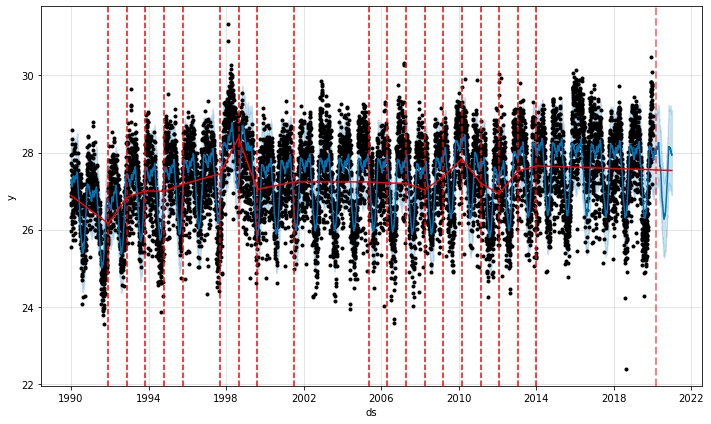

In [51]:

fig = m.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), m, forecast)
ax = fig.add_subplot(111)
ax.axvline(x=forecast['ds'].max() - pd.Timedelta('300 days'), c='red', lw=2, alpha=0.5, ls='--')
fig.show()

In [52]:
# Listing all the change points in the model
deltas = m.params['delta'].mean(0)
cp = pd.DataFrame(m.changepoints)
cp['deltas'] = deltas
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Bar(x=cp['ds'], y=cp['deltas'], name='CPs',))

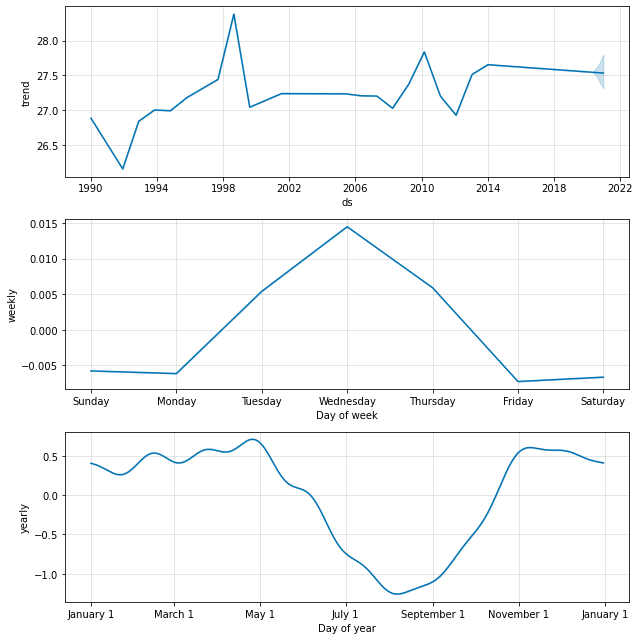

In [53]:
fig = m.plot_components(forecast)

In [55]:

# # Fit the model with two years of data and define a horizon of 365 days forcasting per month
# df_cv = cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')

# cutoffs = df_cv.groupby('cutoff').mean().reset_index()['cutoff']
# cutoff = df_cv['cutoff'].unique()[0]
# df_cv = df_cv[df_cv['cutoff'].values == cutoff]

# fig = plt.figure(facecolor='w', figsize=(10, 6))
# ax = fig.add_subplot(111)
# ax.plot(m.history['ds'].values, m.history['y'], 'k.')
# ax.plot(df_cv['ds'].values, df_cv['yhat'], ls='-', c='#0072B2')
# ax.fill_between(df_cv['ds'].values, df_cv['yhat_lower'],
#                 df_cv['yhat_upper'], color='#0072B2',
#                 alpha=0.2)
# #ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
# ax.set_ylabel('y')
# ax.set_xlabel('ds')

# # Making all the vlines for cutoffs
# for item in cutoffs:
#   ax.axvline(x=pd.to_datetime(item), c='red', lw=2, alpha=0.5, ls='--')

# # Adding text to describe the data set splits
# ax.text(x=pd.to_datetime('2017-07-07'),y=12, s='Initial training data', color='black',
#        fontsize=16, fontweight='bold', alpha=0.8)
# ax.text(x=pd.to_datetime('2018-12-17'),y=24, s='Cutoffs', color='black',
#        fontsize=16, fontweight='bold', alpha=0.8)

# ax.text(x=pd.to_datetime(cutoff) + pd.Timedelta('180 days'),y=24, s='Horizon', color='black',
#        fontsize=16, fontweight='bold', alpha=0.8)

# ax.axvline(x=pd.to_datetime(cutoff) + pd.Timedelta('365 days'), c='gray', lw=4,
#            alpha=0.5, ls='--')

In [ ]:
df_cv.head()

In [ ]:
df_p = performance_metrics(df_cv)
df_p.head(5)

In [ ]:
plot_cross_validation_metric(df_cv, metric='mape')

In [ ]:
df_p.mean()


In [ ]:

def getPerformanceMetrics(m):
  return performance_metrics(getCrossValidationData(m))

def getCrossValidationData(m):
 return cross_validation(m, initial='730 days', period = '31 days', horizon = '365 days')

In [ ]:

m = Prophet()
m.add_country_holidays(country_name='ID')
m.fit(df_daily_temp)
# List the holiday names
m.train_holiday_names

In [ ]:
# Hyperparameters
PERIODS = 300
FREQ = 'D'

# Forecasting
m = Prophet()

# add holiday
m.add_country_holidays(country_name='NO')
 
# Fit the data. Remember that prophet expect "ds" and "y" as names for the columns.
m.fit(df_daily_temp)
 
# We must create a data frame holding dates for our forecast. The periods # parameter counts days as long as the frequency is 'D' for the day. Let's # do a 180 day forecast, approximately half a year.
future = m.make_future_dataframe(periods=PERIODS, freq=FREQ)
# Create the forecast object which will hold all of the resulting data from the forecast.
forecast = m.predict(future)

In [ ]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_daily_temp['ds'], y=df_daily_temp['y'], name='Actual',))
fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['yhat'], name='Predicted',))
# fig.add_trace(go.Scatter(x=forecast['ds'], y=forecast['holidays'], name='Holidays',))
fig.show()